# Model profiles using different type of source redshift information as input

In this example we model profile by giving as input either : 
- discrete source redshifts, 
- a redshift distribution function,
- the value of the mean beta parameters : 
$\langle \beta_s \rangle = \left\langle \frac{D_{LS}}{D_S}\frac{D_\infty}{D_{L,\infty}}\right\rangle$ ,
$\langle \beta_s^2 \rangle = \left\langle \left(\frac{D_{LS}}{D_S}\frac{D_\infty}{D_{L,\infty}}\right)^2 \right\rangle$

In [2]:
import warnings
warnings.filterwarnings("ignore", message='.*(!).*')
import os
## Uncomment the following line if you want to use a specific modeling backend among 'ct' (cluster-toolkit), 'ccl' (CCL) or 'nc' (Numcosmo). Default is 'ccl'
#os.environ['CLMM_MODELING_BACKEND'] = 'nc'

In [3]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make sure we know which version we're using

In [4]:
clmm.__version__

'1.3.4'

## Import mock data module and setup the configuration 

In [5]:
from clmm.support import mock_data as mock
from clmm import Cosmology

Mock data generation requires a defined cosmology

In [6]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

Mock data generation requires some cluster information. The default is to work with the NFW profile, using the "200,mean" mass definition. The Numcosmo and CCL backends allow for more flexibility (see last section of this notebook)

In [7]:
cosmo = mock_cosmo

# cluster properties from https://arxiv.org/pdf/1611.03866.pdf
cluster_id = "SPT-CL J0000−5748"
cluster_m = 4.56e14 # M500,c
cluster_z = 0.702
cluster_ra = 0.2499 
cluster_dec = -57.8064
concentration = 5 # (arbitrary value, not from the paper)

#source redshift distribution properties
beta_s_mean = 0.466
beta_s2_mean = 0.243
ngal_density= 26. # density of source galaxies per arcmin^2 # (arbitrary value, not from the paper)
model_z_distrib = "desc_srd"
zsrc_min = cluster_z + 0.1 

# 1 - Discrete redshifts

### Generate the mock source catalog

In [8]:
source_catalog = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                                   model_z_distrib, zsrc_min=zsrc_min, zsrc_max=7.0, ngal_density=ngal_density, 
                                                   cluster_ra=cluster_ra, cluster_dec=cluster_dec)


# 2 - Redshift distribution

In [19]:
def z_distrib_model_p(model):
    """
    A private function that returns unnormalized galaxy redshift distribution
    function, with the fiducial set of parameters, given the parametrisation model specified.

    Parameters
    ----------
    redshift : float
        Galaxy redshift
    model : str
        Name of the parametrisation model of the desired redshift distribution function.
        Supported models are `Chang_et_al_2013` for Chang et al (2013) and `desc_srd` for
        the LSST/DESC Science Requirement Document (arxiv:1809.01669).
    is_cdf : bool
        If True, returns cumulative distribution function.

    Returns
    -------
    The value of the distribution at z for the given model name.
    """
    if model == "Chang_et_al_2013":
        return clmm.utils._chang_z_distrib
    elif model == "desc_srd":
        return clmm.utils._srd_z_distrib
    else:
        raise ValueError(f"Unsupported model (='{model}')")


In [20]:
z = np.linspace(0,7,1000)

In [21]:
z_distrib_model_p(model=model_z_distrib)

<function clmm.utils._srd_z_distrib(redshift, is_cdf=False)>

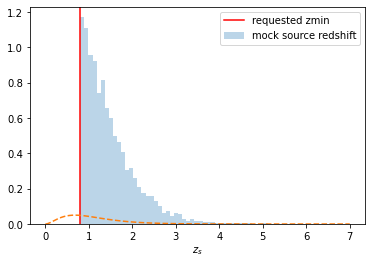

In [28]:
plt.hist(source_catalog['z'], bins=50, alpha=0.3, density=True, label='mock source redshift');
plt.axvline(zsrc_min, color='red', label='requested zmin')
plt.plot(z,z_distrib_model_p(model=model_z_distrib)(z), linestyle='dashed')
plt.xlabel('$z_s$')
plt.legend()

## Populate a galaxy cluster object

In [ ]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, allsystematics)

From a `GalaxyCluster` object that has photoz information, `draw_gal_z_from_pdz` allows to generate `nobj` random redshifts of each galaxy in `galcat`, from its photoz pdf, and store the result in a new `zcol_out` column.

In [ ]:
z_random = gc_object.draw_gal_z_from_pdz(zcol_out='z_random', overwrite=False, nobj=1)

The plot below shows the "observed photoz pdf" (blue), centered on the "observed z" (red), the true redshift from which the shear where computed (green) and  a random redshift (orange) computed from the pdf

In [ ]:
# pdz for one of the galaxy in the catalog, 
galid = 0
plt.plot(gc_object.galcat['pzbins'][galid], gc_object.galcat['pzpdf'][galid], label='Photoz pdf')
plt.axvline(gc_object.galcat['z'][galid], label='Observed z', color='red')
plt.axvline(gc_object.galcat['ztrue'][galid], label='True z', color='g')
plt.axvline(gc_object.galcat['z_random'][galid], label='Random z from pdf', color='orange')
plt.xlabel('Redshift')
plt.ylabel('Photo-z Probability Distribution')
plt.legend(loc=1)

Plot source galaxy ellipticities

In [ ]:
plt.scatter(gc_object.galcat['e1'],gc_object.galcat['e2'])

plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Ellipticity 1',fontsize='x-large')
plt.ylabel('Ellipticity 2',fontsize='x-large')

## Generate the mock data catalog with different field-of-view options

In the examples above, `ngals=1000` galaxies were simulated in a field corresponding to a 8 Mpc x 8 Mpc (proper distance) square box at the cluster redshift (this is the default). The user may however vary the field size and/or provide a galaxy density (instead of a number of galaxies). This is examplified below, using the `allsystematics` example.

- `ngals = 1000` in a 4 x 4 Mpc box. Asking for the same number of galaxies in a smaller field of view yields high galaxy density

In [ ]:
allsystematics2 = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                               'chang13', zsrc_min=zsrc_min, zsrc_max=7.0, 
                                               shapenoise=0.05, photoz_sigma_unscaled=0.05,
                                               field_size=4, ngals=ngals, 
                                               cluster_ra=cluster_ra, cluster_dec=cluster_dec)

In [ ]:
plt.scatter(allsystematics['ra'],allsystematics['dec'], marker='.', label = 'default 8 x 8 Mpc FoV')
plt.scatter(allsystematics2['ra'],allsystematics2['dec'],marker='.', label = 'user-defined FoV')
plt.legend()

- Alternatively, the user may provide a galaxy density (here ~1 gal/arcmin2 to roughly match 1000 galaxies, given the configuration) and the number of galaxies to draw will automatically be adjusted to the box size.

In [ ]:
allsystematics3 = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                               'chang13', zsrc_min=zsrc_min, zsrc_max=7.0, 
                                              shapenoise=0.05, photoz_sigma_unscaled=0.05, 
                                              ngal_density=1.3,
                                              cluster_ra=cluster_ra, cluster_dec=cluster_dec)
print(f'Number of drawn galaxies = {len(allsystematics3)}')

In [ ]:
allsystematics4 = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                               'desc_srd', zsrc_min=zsrc_min, zsrc_max=7.0, 
                                              shapenoise=0.05, photoz_sigma_unscaled=0.05, 
                                              ngal_density=1.3,
                                              cluster_ra=cluster_ra, cluster_dec=cluster_dec)
print(f'Number of drawn galaxies = {len(allsystematics4)}')

In [ ]:
plt.scatter(allsystematics['ra'],allsystematics['dec'], marker='.', label = 'ngals = 1000')
plt.scatter(allsystematics3['ra'],allsystematics3['dec'],marker='.', label = 'ngal_density = 1 gal / arcmin2')
plt.legend()

## Generate mock data with different galaxy cluster options
WARNING: Available options depend on the modeling backend:
- Cluster-toolkit allows for other values of the overdensity parameter, but is retricted to working with the mean mass definition
- Both CCL and Numcosmo allow for different values of the overdensity parameter, but work with both the mean and critical mass definition
- Numcosmo further allows for the Einasto or Burkert density profiles to be used instead of the NFW profile



### Changing the overdensity parameter (all backend) - `delta_so` keyword (default = 200)

In [ ]:
allsystematics_500mean = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'chang13', delta_so=500,
    zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals,
    cluster_ra=cluster_ra, cluster_dec=cluster_dec)

### Using the critical mass definition (Numcosmo and CCL only) - `massdef` keyword (default = 'mean')
WARNING: error will be raised if using the cluster-toolkit backend

In [ ]:
allsystematics_200critical = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo,'chang13',  massdef='critical', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals,
    cluster_ra=cluster_ra, cluster_dec=cluster_dec)

### Changing the halo density profile (Numcosmo and CCL only) - `halo_profile_model` keyword (default = 'nfw')
WARNING: error will be raised if using the cluster-toolkit or CCL backends

In [ ]:
allsystematics_200m_einasto = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo,'chang13', halo_profile_model='einasto', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals,
    cluster_ra=cluster_ra, cluster_dec=cluster_dec)